In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet langchain-groq
!pip install --quiet wikipedia
!pip install --quiet google-generativeai
!pip install --quiet duckduckgo-search


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.0 MB/s eta 0:00:00


In [60]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass
import time
import asyncio

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.retrievers import WikipediaRetriever
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from openai import OpenAI

In [61]:
google_api_key = userdata.get('GOOGLE_API_KEY')

gemini_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=google_api_key
                              )

# model.invoke("Test")

In [62]:
api_key = userdata.get("GROQ_API_KEY")

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    verbose=True,
    temperature=0.5,
    api_key=api_key
)

model.invoke('TEST').content

"It looks like you're testing to see if I'm working properly. Is there anything else I can help you with or would you like to have a conversation?"

In [63]:
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("TAVILY_API_KEY")

In [97]:
memory = MemorySaver()

class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  analysis: str
  pro_debator_response: str
  anti_debator_response: str
  context: Annotated[list, add_messages]
  debate: Annotated[list, add_messages]
  debate_history: List[str]
  iteration: int
  max_iteration: int

# class SearchQuery(BaseModel):
#   search_query: str = Field(description="The search query for retrieval")

# structure_llm = model.with_structured_output(SearchQuery)
# structure_llm

In [98]:

def measure_time(node_function):
    """Decorator to measure and log the execution time of a node function."""
    def wrapper(state, *args, **kwargs):
        start_time = time.time()
        print(f"Starting node: {node_function.__name__}")
        result = node_function(state, *args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Node {node_function.__name__} completed in {elapsed_time:.2f} seconds.\n")

        # Optionally store in state for later analysis
        if "node_times" not in state:
            state["node_times"] = {}
        state["node_times"][node_function.__name__] = elapsed_time

        return result
    return wrapper



In [112]:
@measure_time
def greeting_node(state: State):
    """LangGraph node that greets the debaters and introduces them"""
    print("Greeting Node")
    topic = state['topic']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']

    prompt = f"""
    You are a professional and unbiased debate host introducing a debate between two participants:
    - {pro_debator}, who supports the topic.
    - {anti_debator}, who opposes the topic.
    Topic: "{topic}"
    Instructions:
    1. Clearly and briefly introduce the participants and the topic to the audience.
    2. Avoid opinions, commentary, or humor. Maintain a formal and neutral tone.
    3. Do not include information not provided in this prompt. Keep the introduction concise, no more than 3 sentences.
    4. Ensure the output is free from errors or irrelevant content.
    Format:
    - Start by welcoming the audience.
    - Introduce the participants and their respective backgrounds.
    - Introduce the topic of debate like a host.
    """

    greetings = model.invoke(prompt).content
    return {"greetings": greetings}


@measure_time
def analyzer_node(state: State):
    """LangGraph node that analyzes the latest argument for web search"""
    print("Analyzer Node")
    topic = state['topic']
    debate = state['debate']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    last_message = debate[-1]
    analysis_prompt = None

    if isinstance(last_message, HumanMessage):
        print("Analyzing for Anti Debator")
        analysis_prompt = f"""
        You are an expert debate analyst providing guidance for effective counterarguments.
        Task:
        Analyze the most recent argument presented by the pro-debator, {pro_debator}, on the topic "{topic}".
        - Highlight the key strengths and logical points of the argument.
        - Identify weaknesses, gaps, or fallacies in the argument, if any.
        - Provide specific and actionable guidance to help the anti-debator, {anti_debator}, develop a strong refutation.
        Constraints:
        - Keep the analysis concise and relevant, limited to 3-4 sentences.
        - Avoid including opinions or unsupported assumptions.
        - Only use information provided in the argument below.
        Argument by Pro-Debator:
        "{last_message.content}"
        """

    elif isinstance(last_message, AIMessage):
        # Analysis for an AIMessage (anti-debator's counterargument)
        print("Analyzing for Pro Debator")
        analysis_prompt = f"""
        You are an expert debate analyst providing guidance for effective counterarguments.
        Task:
        Analyze the most recent counterargument presented by the anti-debator, {anti_debator}, on the topic "{topic}".
        - Highlight the key points and logical strengths of the counterargument.
        - Identify weaknesses, gaps, or fallacies in the counterargument, if any.
        - Provide specific and actionable guidance to help the pro-debator, {pro_debator}, effectively refute these points.
        Constraints:
        - Keep the analysis concise and relevant, limited to 3-4 sentences.
        - Avoid including opinions or unsupported assumptions.
        - Only use information provided in the counterargument below.
        Counterargument by Anti-Debator:
        "{last_message.content}"
        """

    analysis = model.invoke(analysis_prompt).content
    return {"analysis": analysis}



@measure_time
def search_web(state: State):
    """LangGraph node to search the web using Tavily Search API and append the results to context."""
    analysis = state['analysis']
    context = state['context']
    debate_history = state['debate_history']
    # Generate a concise and focused search query
    search_query_prompt = f"""
    You are a search assistant creating a concise and high-quality web search query.
    Task:
    Based on the following debate history and analysis, generate a single-sentence search query:
    - The query must focus on retrieving factual information, particularly numeric data, statistics, or figures directly relevant to the topic.
    - Avoid verbose or generic phrasing. Be as specific as possible.
    Analysis:
    "{analysis}"
    Debate History:
    "{debate_history}"
    Output:
    A single, short and concise search query focusing on numeric data.
    """
    search_query = model.invoke(search_query_prompt).content.strip()
    # Perform the web search
    search = DuckDuckGoSearchResults(backend="news", output_format='list')
    search_result = search.invoke(search_query)
    # Compile results
    result = ""
    for entry in search_result:
        print(entry['snippet'])
        result += entry['snippet'] + "\n"

    print(state['context'])
    return {"context": [result]}


@measure_time
def search_wikipedia(state: State):
    """Retrieve docs from Wikipedia using WikipediaRetriever"""
    print("Searching Wikipedia")

    # Analysis and debate context
    analysis = state['analysis']
    debate_history = state['debate_history']

    # Generate a concise, single-sentence Wikipedia search query
    search_query_prompt = f"""
    You are a search assistant generating a concise search query for Wikipedia.
    Task:
    Based on the analysis and debate history provided, generate a single-sentence search query:
    - Focus on retrieving relevant and factual information from Wikipedia.
    - Avoid verbose or redundant phrasing.
    Analysis:
    "{analysis}"
    Debate History:
    "{debate_history}"
    Output:
    A single concise search query relevant to the topic.
    """
    search_query = model.invoke(search_query_prompt).content.strip()
    print("Wikipedia Search Query:", search_query)

    retriever = WikipediaRetriever()
    search_docs = retriever.invoke(search_query)
    all_summaries = ""
    for doc in search_docs:
        if 'summary' in doc.metadata:
            all_summaries += doc.metadata['summary'] + "\n\n"

    print(f"Wikipedia Docs Summaries: {all_summaries}")
    print(state['context'])
    return {"context": [all_summaries]}


@measure_time
def router(state: State):
    """LangGraph node that routes to the appropriate search function"""
    debate_history = state["debate_history"]
    if debate_history == []:
        return "Pro Debator"
    else:
      return "Analyzer"

def iteration_router(state: State):
    """Routes the flow based on the current iteration and max_iteration"""
    if state['iteration'] >= state['max_iteration']:
        print("Ending the debate as max iteration is reached.")
        return END
    print(f"Iteration Round: {state['iteration']}")
    state['iteration'] += 1  # Failsafe increment
    return "Analyzer"



@measure_time
def analyzer_router(state: State):
    """Function that routes to the appropriate next node"""
    debate = state['debate']
    last_message = debate[-1]
    if isinstance(last_message, AIMessage):
        return "Pro Debator"  # Pro Debator responds to the anti-debator's argument
    else:
        return "Anti Debator"  # Anti Debator responds to the pro-debator's argument


In [113]:
def pro_debator_node(state: State):
    """LangGraph node that represents the pro debator"""

    print("Pro Debator Node")

    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    debate = state.get('debate', [])
    context = state.get('context', "")

    if not anti_debator_response and not debate:
        # Greeting and opening argument scenario
        prompt_template = """
            You are {pro_debator}, presenting the affirmative stance on the topic: "{topic}" in a debate.
            Your goal is to deliver a strong and concise opening argument in favor of "{topic}" in no more than 3-4 sentences.
            Your language should be conversational, persuasive, and directly relevant to the topic. Avoid lengthy introductions.

            Guidelines:
            1. **Persona Alignment**: Use language and phrases consistent with {pro_debator}'s persona.
            2. **Clarity and Brevity**: Make your opening impactful but keep it conversational and limited to 3-4 sentences.
            3. **Focus on Core Argument**: Present clear and logical points without unnecessary elaboration or excessive detail.

            **Context (if applicable)**: {context}

            Begin your opening statement.
        """
        system_message = prompt_template.format(
            pro_debator=pro_debator,
            anti_debator=anti_debator,
            topic=topic,
            context=context
        )
    else:
        # Responding to latest argument scenario
        prompt_template = """
          You are {pro_debator}, presenting your affirmative stance on the topic: "{topic}" in a debate.
          Your task is to directly respond to the latest argument by {anti_debator} in a concise and conversational manner, limited to 3-4 sentences.
          Focus on addressing weaknesses, logical fallacies, or gaps in their argument while maintaining a persuasive tone.

          Guidelines:
          1. **Direct Rebuttal**: Address the latest response from {anti_debator} directly.
          2. **Persona Alignment**: Use language and phrases consistent with {pro_debator}'s persona.
          3. **Clarity and Brevity**: Keep your response impactful but limited to 3-4 sentences.
          4. **Avoid Redundancy**: Leverage details from the debate history to strengthen your response without repeating previous arguments.
          5. **Use Context**: Use relevant details from the context or debate history (if applicable) to make your argument more credible.

          **Debate History**:
          {debate_history}

          **Latest Argument from {anti_debator}**:
          {anti_debator_response}

          **Context**:
          {context}

          Craft your rebuttal.
        """
        system_message = prompt_template.format(
            pro_debator=pro_debator,
            topic=topic,
            anti_debator=anti_debator,
            debate_history=debate_history,
            anti_debator_response=anti_debator_response,
            context=context
        )

    # Generate response using the model
    pro_debator_response_content = gemini_model.invoke(system_message).content

    # Create a HumanMessage with the response content and assign a name
    pro_debator_response = HumanMessage(
        content=f"{pro_debator}: {pro_debator_response_content}",
        name="pro_response"
    )

    debate.append(pro_debator_response)
    return {"pro_debator_response": pro_debator_response, "debate": debate}


In [114]:
def anti_debator_node(state: State):
    """LangGraph node that represents the anti debator"""
    print("Anti Debator Node")
    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    debate = state.get('debate', [])
    context = state.get('context', "")

    # Improved prompt with guardrails
    prompt_template = """
        You are {anti_debator}, presenting your opposing stance on the topic: "{topic}" in a debate.
        Your task is to craft a direct and concise rebuttal to the latest argument provided by {pro_debator}.
        The opinion should reflect a real stance that {anti_debator} has taken on the topic "{topic}" and align with their persona.

        Guidelines for crafting your rebuttal:
        1. **Direct Rebuttal**: Respond specifically to the latest argument from {pro_debator}. Address any logical flaws, missing evidence, or weak points while maintaining a respectful tone.
        2. **Clarity and Brevity**: Limit your response to no more than 3 sentences. Ensure it is conversational, impactful, and easy to follow.
        3. **Debate Continuity**: Use relevant details from the debate history (if provided) to strengthen your response while avoiding redundancy.
        4. **Persona Consistency**: Use language, phrases, and tone that align with {anti_debator}'s persona and style of communication.
        5. **Guardrails**: Avoid unsupported claims, personal attacks, or unrelated points. Stick to the topic and present logical arguments.
        6. **Use of Context**: Incorporate credible evidence or insights from the provided context (if applicable) to make your argument more persuasive.

        **Context (if applicable)**:
        {context}

        **Debate History (recent exchanges)**:
        {debate_history}

        **Latest Argument from {pro_debator}**:
        {pro_debator_response}

        **Your Rebuttal**:
    """

    # Generate the system message for the model
    system_message = prompt_template.format(
        topic=topic,
        pro_debator=pro_debator,
        pro_debator_response=anti_debator_response,
        anti_debator=anti_debator,
        debate_history=debate_history,
        context=context
    )

    # Generate response using the model
    anti_debator_response_content = gemini_model.invoke(system_message).content

    # Create an AIMessage with the response content and assign a name
    anti_debator_response = AIMessage(
        content=f"{anti_debator}: {anti_debator_response_content}",
        name="anti_response"
    )

    debate.append(anti_debator_response)
    return {"anti_debator_response": anti_debator_response, "debate": debate}


In [115]:
@measure_time
def debate_summarizer_node(state: State):
  """LangGraph node that summarizes the exchange of arguments between debator
  and append to history for future consideration
  """
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']
  debate_history = state['debate_history']
  anti_debator_response = state['anti_debator_response']
  pro_debator_response = state['pro_debator_response']
  prompt = """
            Summarize the conversation between the pro {pro_debator} and anti debator {anti_debator},
            highlighting the key points of their arguments and discarding unnecessary points. The
            summary should be concise and brief, with high quality.
            **Instructions:**
            * Focus on the core arguments presented by both sides.
            * Identify the main points of agreement and disagreement.
            * Provide a clear and objective overview of the debate.
            * Avoid including irrelevant details or repetitive information.
            * Ensure that the summary is easy to understand and informative.
            **Pro Debator:**
            {pro_debator_response}
            **Anti Debator:**
            {anti_debator_response}
          """
  system_message = prompt.format(
                      pro_debator=pro_debator,
                      pro_debator_response=pro_debator_response,
                      anti_debator=anti_debator,
                      anti_debator_response=anti_debator_response,
                    )
  summary = model.invoke(system_message).content
  debate_history.append(summary)
  state['debate_history'] = debate_history
  state['iteration'] += 1
  print(f"Updated Iteration: {state['iteration']}")
  return state



In [116]:
async def streaming_response_node(state: State):
  last_message = state['debate'][-1]
  yield {"stream": last_message}

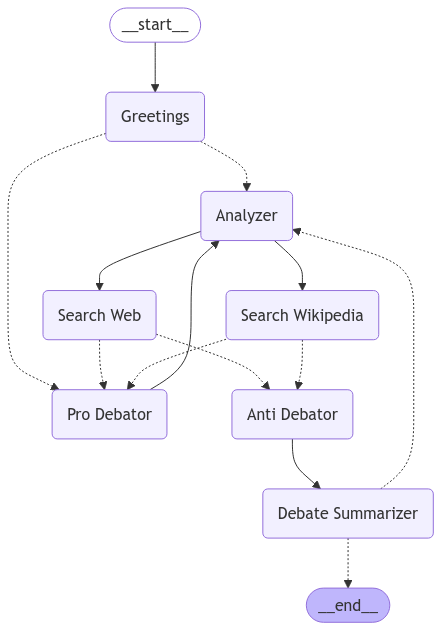

In [104]:
builder = StateGraph(State)
# Add nodes
builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)
builder.add_node("Analyzer", analyzer_node)
builder.add_node("Search Web", search_web)
builder.add_node("Search Wikipedia", search_wikipedia)
builder.add_node("Anti Debator", anti_debator_node)
builder.add_node("Debate Summarizer", debate_summarizer_node)

# Add edges
builder.add_edge(START, "Greetings")
builder.add_conditional_edges("Greetings", router, ['Analyzer', 'Pro Debator'])
builder.add_edge("Analyzer", "Search Web")
builder.add_edge("Analyzer", "Search Wikipedia")
builder.add_conditional_edges("Search Web", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_conditional_edges("Search Wikipedia", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_edge("Pro Debator", "Analyzer")
builder.add_edge("Anti Debator", "Debate Summarizer")
builder.add_conditional_edges(
    "Debate Summarizer",
    iteration_router,
    ["Analyzer", END]
)


# Compile the graph
debator = builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# Display the graph
display(Image(debator.get_graph().draw_mermaid_png()))


In [105]:
state = {
    "topic": "illegal immigration",
    "pro_debator": "Kamala Harris",
    "anti_debator": "Donald Trump",
    "greetings": "",
    "analysis": "",
    "pro_debator_response": "",
    "anti_debator_response": "",
    "context": [],
    "debate": [],
    "debate_history": [],
    "iteration": 0,
    "max_iteration": 2
}


In [106]:
thread = {"configurable": {"thread_id": "1"}}
result = debator.invoke(state, thread)
result

Starting node: greeting_node
Greeting Node
Node greeting_node completed in 0.54 seconds.

Starting node: router
Node router completed in 0.00 seconds.

Pro Debator Node
Starting node: analyzer_node
Analyzer Node
Analyzing for Anti Debator
Node analyzer_node completed in 1.27 seconds.

Starting node: search_web
Starting node: search_wikipedia
Searching Wikipedia
Wikipedia Search Query: "Kamala Harris immigration policy"
Node search_web completed in 0.64 seconds.

Starting node: analyzer_router
Node analyzer_router completed in 0.00 seconds.

Wikipedia Docs Summaries: 
Node search_wikipedia completed in 0.64 seconds.

Starting node: analyzer_router
Node analyzer_router completed in 0.00 seconds.

Anti Debator Node
Starting node: debate_summarizer_node
Updated Iteration: 1
Node debate_summarizer_node completed in 1.46 seconds.

Iteration Round: 1
Starting node: analyzer_node
Analyzer Node
Analyzing for Pro Debator
Node analyzer_node completed in 0.98 seconds.

Starting node: search_webSta

{'topic': 'illegal immigration',
 'pro_debator': 'Kamala Harris',
 'anti_debator': 'Donald Trump',
 'greetings': 'Ladies and gentlemen, welcome to tonight\'s debate. We have the honor of hosting two distinguished guests: Senator Kamala Harris, a former Attorney General of California and a prominent figure in American politics, and Donald Trump, the 45th President of the United States and a renowned businessman. Tonight, they will engage in a discussion on the topic of "illegal immigration," with Senator Harris arguing in support of a more permissive approach and President Trump arguing in opposition.',
 'analysis': 'Analysis:\n\nKey strengths of Kamala Harris\' argument include:\n- Framing the issue as complex, requiring a multifaceted approach rather than a singular solution (wall).\n- Implying that Trump\'s solution is outdated and inhumane, which may evoke emotional responses from the audience.\n\nWeaknesses and gaps in the argument:\n- Lack of specific examples or data to support t

In [107]:
pprint.pprint(result['greetings'])

("Ladies and gentlemen, welcome to tonight's debate. We have the honor of "
 'hosting two distinguished guests: Senator Kamala Harris, a former Attorney '
 'General of California and a prominent figure in American politics, and '
 'Donald Trump, the 45th President of the United States and a renowned '
 'businessman. Tonight, they will engage in a discussion on the topic of '
 '"illegal immigration," with Senator Harris arguing in support of a more '
 'permissive approach and President Trump arguing in opposition.')


In [108]:
import pprint
pprint.pprint(result['pro_debator_response'].content)

('Kamala Harris: With all due respect, Mr. Trump,  calling our border a '
 '"disaster" is a simplification.  Focusing solely on a wall ignores the '
 'complex root causes of migration and the proven effectiveness of '
 'comprehensive strategies.  Your solution is outdated and frankly, '
 'inhumane.\n')


In [109]:
pprint.pprint(result['anti_debator_response'].content)

('Donald Trump: Wrong, Kamala.  The border *is* a disaster, and your '
 'open-borders policies are making it worse.  A wall works, and it’s common '
 'sense – unlike your failed approach.\n')


In [110]:
pprint.pprint(result['analysis'])

('Analysis:\n'
 '\n'
 "Key strengths of Kamala Harris' argument include:\n"
 '- Framing the issue as complex, requiring a multifaceted approach rather '
 'than a singular solution (wall).\n'
 "- Implying that Trump's solution is outdated and inhumane, which may evoke "
 'emotional responses from the audience.\n'
 '\n'
 'Weaknesses and gaps in the argument:\n'
 '- Lack of specific examples or data to support the effectiveness of '
 'comprehensive strategies.\n'
 "- The argument relies on an emotional appeal (calling Trump's solution "
 '"inhumane") rather than providing concrete evidence.\n'
 '\n'
 "Guidance for Donald Trump's refutation:\n"
 '- Challenge Harris to provide concrete evidence and data to support the '
 'effectiveness of comprehensive strategies.\n'
 '- Counter her emotional appeal by highlighting the humanitarian concerns '
 'related to unregulated immigration, such as human trafficking and national '
 'security risks.\n'
 '- Emphasize the need for a physical barrier as a

In [111]:
result['debate']

[HumanMessage(content='Kamala Harris: Let\'s be clear:  the term "illegal immigration" itself is problematic, framing human beings as criminals.  We need a humane and comprehensive approach to immigration, recognizing the contributions immigrants make to our economy and society.  Focusing solely on enforcement ignores the underlying issues driving migration and the real human stories behind them.\n', additional_kwargs={}, response_metadata={}, name='pro_response', id='c38a998a-2640-477c-b31d-8ace476fc58a'),
 AIMessage(content="Donald Trump: Kamala, you talk a good game, but the facts don't lie.  Our border is a disaster, and your policies haven't fixed it.  We need a wall, and we need it now.\n", additional_kwargs={}, response_metadata={}, name='anti_response', id='027c2876-d2bd-4150-8efc-f2803f217d06'),
 HumanMessage(content='Kamala Harris: With all due respect, Mr. Trump,  calling our border a "disaster" is a simplification.  Focusing solely on a wall ignores the complex root causes 

In [78]:
result['debate_history']

['**Debate Summary: Border Security and Immigration Reform**\n\n**Key Points:**\n\n* **Pro Debator (Kamala Harris):**\n\t+ Progress has been made in strengthening border security.\n\t+ Comprehensive immigration reform and addressing root causes of migration are necessary.\n\t+ Building walls is not a solution and creates more problems.\n* **Anti Debator (Donald Trump):**\n\t+ Strong borders are necessary for safety and upholding the rule of law.\n\t+ Compassion does not mean open borders.\n\n**Main Points of Agreement and Disagreement:**\n\n* **Agreement:** Both debators acknowledge the importance of border security.\n* **Disagreement:**\n\t+ Approach to border security: Harris advocates for comprehensive reform, while Trump emphasizes strong borders and walls.\n\t+ Definition of compassion: Harris believes compassion involves addressing root causes of migration, while Trump sees it as distinct from open borders.\n\n**Objective Overview:**\nThe debate highlights fundamental differences